In [174]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error

In [2]:
orig_data = pd.read_excel("OppScrData.xlsx")
for col in orig_data.columns:
    new_col = '_'.join(col.split())
    orig_data.rename(columns={col:new_col}, inplace=True)

In [23]:
orig_data.columns[:55]

Index(['Record_ID', 'Visit_ID', 'PT_ID', 'Clinical_F/U_interval_[d_from_CT]',
       'BMI', 'BMI_>30', 'Sex', 'Age_at_CT', 'Tobacco', 'Alcohol_abuse',
       'FRS_10-year_risk_(%)', 'FRAX_10y_Fx_Prob_(Orange-w/_DXA)',
       'FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)', 'Met_Sx', 'CLINICAL_OUTCOMES',
       'DEATH_[d_from_CT]', 'CVD_DX', 'CVD_DX_Date_[d_from_CT]',
       'Heart_failure_DX', 'Heart_failure_DX_Date_[d_from_CT]', 'MI_DX',
       'MI_DX_Date_[d_from_CT]', 'Type_2_Diabetes_DX',
       'Type_2_Diabetes_DX_Date_[d_from_CT]', 'Femoral_neck_fracture_DX',
       'Femoral_neck_fracture_DX_Date_[d_from_CT]',
       'Unspec_femoral_fracture_DX',
       'Unspec_femoral_fracture_DX_Date_[d_from_CT]', 'Forearm_fracture_DX',
       'Forearm_fracture_DX_Date_[d_from_CT]', 'Humerus_fracture_DX',
       'Humerus_fracture_DX_Date_[d_from_CT]', 'Pathologic_fracture_DX',
       'Pathologic_fracture_DX_Date_[d_from_CT]', 'Alzheimers_DX',
       'Alzheimers_DX_Date_[d_from_CT]', 'Primary_Cancer_Site

In [25]:
orig_data['Met_Sx'].value_counts()

N    7047
Y     738
Name: Met_Sx, dtype: int64

In [162]:
data = orig_data[['Record_ID', 'Visit_ID', 'PT_ID','DEATH_[d_from_CT]','L1_HU_BMD',
       'TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'VAT_Area_(cm2)',
       'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
       'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']]

col = 'Liver_HU_(Median)'
data[col] = pd.to_numeric(data[col], errors='coerce')
data[col] = data[col].astype(float)

# data['DEATH_[d_from_CT]'].fillna(5071, inplace=True)
# # data = data[(data['DEATH_[d_from_CT]']<=1825) | (data['DEATH_[d_from_CT]']>=3650)]
# data['death'] = np.where(data['DEATH_[d_from_CT]']<=5070,1,0)

msk = np.random.rand(data.shape[0]) < 0.8
train = data[msk]
test = data[~msk]

feats = ['L1_HU_BMD',
       'TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'VAT_Area_(cm2)',
       'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
       'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']
label = 'death'

/var/folders/vj/qcl266c92812js646m8tcfgc0000gn/T/ipykernel_54692/973090420.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = pd.to_numeric(data[col], errors='coerce')
/var/folders/vj/qcl266c92812js646m8tcfgc0000gn/T/ipykernel_54692/973090420.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].astype(float)


## EDA

In [7]:
orig_data[~orig_data['DEATH_[d_from_CT]'].isna()].shape

(549, 115)

<AxesSubplot:ylabel='Frequency'>

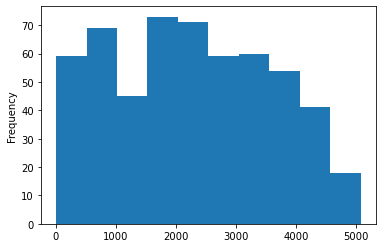

In [120]:
orig_data[orig_data['DEATH_[d_from_CT]']<5071]['DEATH_[d_from_CT]'].plot.hist()

In [90]:
train.groupby('death')['L1_HU_BMD',
       'TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'VAT_Area_(cm2)',
       'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
       'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)'].describe().T[48:]

/var/folders/vj/qcl266c92812js646m8tcfgc0000gn/T/ipykernel_12352/3844569056.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  train.groupby('death')['L1_HU_BMD',


death                               0             1
Muscle_HU         count   7122.000000     39.000000
                  mean      29.277051     17.959249
                  std       11.992602     16.283023
                  min     -118.307532    -18.003310
                  25%       22.584768      6.859847
                  50%       31.041427     19.931802
                  75%       37.776270     27.836226
                  max       99.484949     54.114002
Muscle_Area_(cm2) count   7122.000000     39.000000
                  mean     154.369044    140.999729
                  std       43.256492     43.182986
                  min        9.376304     38.313354
                  25%      122.003265    112.699118
                  50%      147.655222    144.886871
                  75%      186.043769    173.386357
                  max      378.491765    231.515391
L3_SMI_(cm2/m2)   count   7047.000000     35.000000
                  mean      52.805568     47.520130
                  std       12.418854     14.135856
                  min        0.562102     14.392344
                  25%       44.471085     40.927373
                  50%       51.878866     48.413187
                  75%       60.766516     54.151315
                  max      139.815667     74.476463
AoCa_Agatston     count   7140.000000     40.000000
                  mean     639.650641   3765.079275
                  std     1655.711369   4795.384406
                  min        0.000000      0.000000
                  25%        0.000000    138.017250
                  50%       52.334000   1750.967500
                  75%      453.395250   5667.641000
                  max    36942.923000  21081.402000
Liver_HU_(Median) count   7092.000000     34.000000
                  mean      55.427806     52.029412
                  std       10.357698     13.732256
                  min       -8.000000     25.000000
                  25%       52.000000     46.250000
                  50%       58.000000     52.500000
                  75%       62.000000     57.500000
                  max       84.000000    105.000000

Record_ID


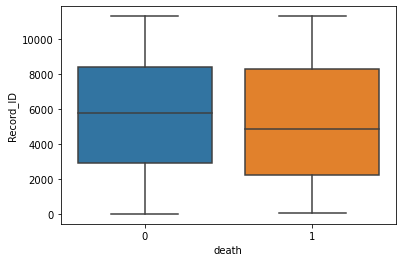

Visit_ID


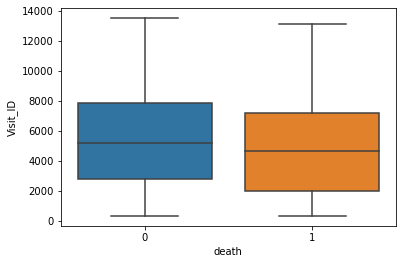

PT_ID


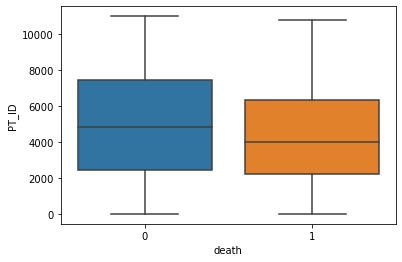

DEATH_[d_from_CT]


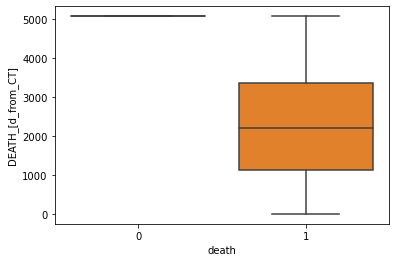

L1_HU_BMD


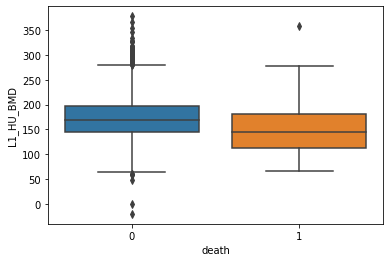

TAT_Area_(cm2)


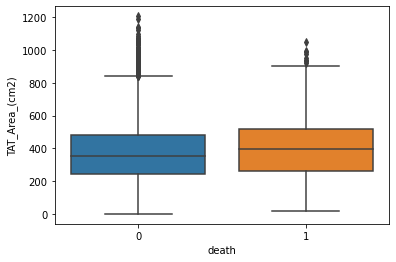

Total_Body_Area_EA_(cm2)


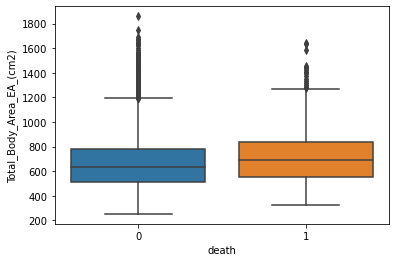

VAT_Area_(cm2)


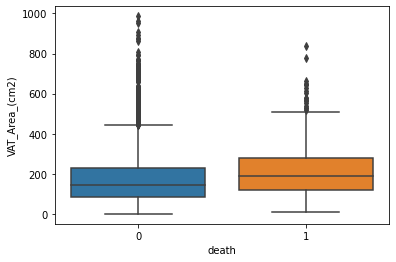

SAT_Area_(cm2)


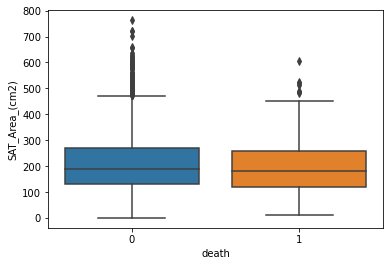

VAT/SAT_Ratio


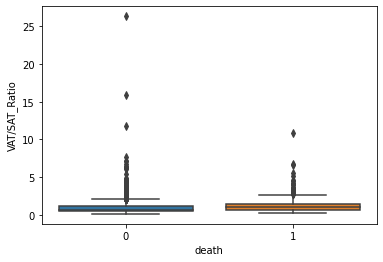

Muscle_HU


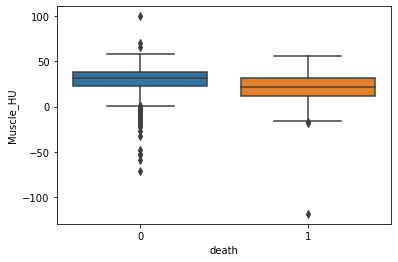

Muscle_Area_(cm2)


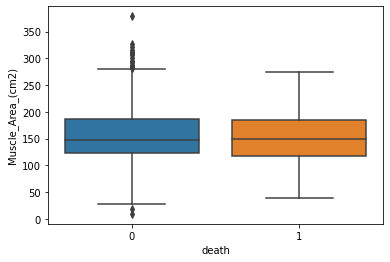

L3_SMI_(cm2/m2)


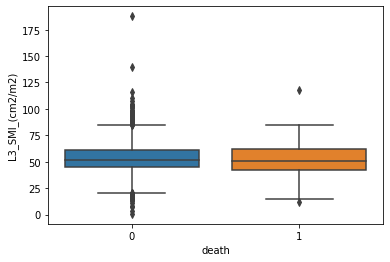

AoCa_Agatston


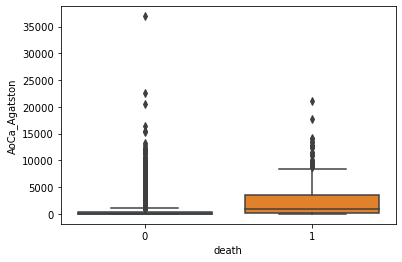

Liver_HU_(Median)


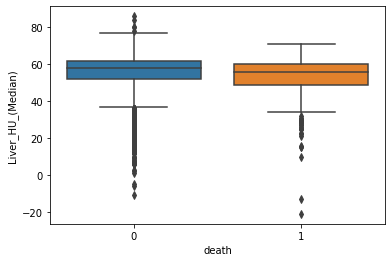

death


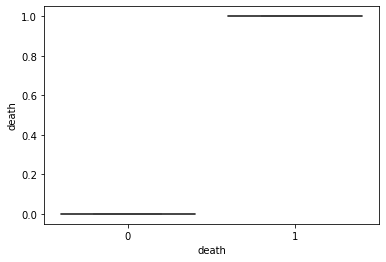

In [114]:
import seaborn as sns
for col in train.columns:
    print(col)
    sns.boxplot(x='death', y=col, data=train)
    plt.show()

In [ ]:
def scale(quantity):
    mn = quantity.min()
    mx = quantity.max()
    scaled_quantity = (quantity - mn)/(mx-mn)
    return scaled_quantity

tmp = data[~data['DEATH_[d_from_CT]'].isna()]
for col in feats:
    x1 = scale(tmp[col])
    x2 = scale(tmp['DEATH_[d_from_CT]'])
    x1 = x1.reindex()
    x2 = x2.reindex()
    sns.lineplot(data=tmp, x=col, y='DEATH_[d_from_CT]')
    plt.show()
    

# -----------------------------------------

## Classfication

In [3]:
na_dict = {}
for col in feats:
    mean = train[col].mean() 
    na_dict[col] = mean
    train[col].fillna(mean, inplace=True)

NameError: name 'feats' is not defined

In [116]:
X_train = train[feats]
Y_train = train[label]

In [117]:
model = LogisticRegression(random_state=0).fit(X_train, Y_train)

/Users/hsahu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [118]:
for col in feats:
    test[col].fillna(na_dict[col], inplace=True)
X_test = test[feats]
Y_test = test[label]
preds = model.predict(X_test)
accuracy_score(Y_test, preds)


/Users/hsahu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


array([[1779,    5],
       [ 110,    5]])

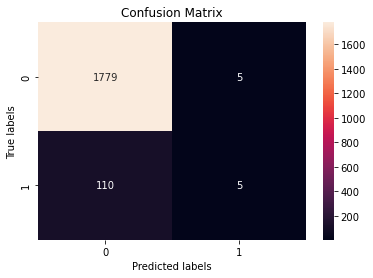

In [123]:
ax= plt.subplot()
cm = confusion_matrix(Y_test, preds)
labels = [0,1]
sns.heatmap(cm, annot=True, fmt='g', ax=ax);
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); 
ax.yaxis.set_ticklabels(labels);

## Heart Attack

In [4]:
# Age at CT
# Tobacco
# BMI
# FRS 10-year risk (%)
# CVD DX
# CVD DX Date [d from CT]
# Heart failure DX
# Heart failure DX Date [d from CT]
# TAT Area (cm2)
# Total Body                
# Area EA (cm2)
# VAT Area (cm2)
# SAT Area (cm2)
# VAT/SAT     Ratio
# AoCa        Agatston
# Liver HU    (Median)

cols = ['Record_ID','BMI','Sex','Age_at_CT','Tobacco','FRS_10-year_risk_(%)','CVD_DX','CVD_DX_Date_[d_from_CT]','Heart_failure_DX','Heart_failure_DX_Date_[d_from_CT]',
'TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'VAT_Area_(cm2)','SAT_Area_(cm2)', 'VAT/SAT_Ratio',
 'AoCa_Agatston', 'Liver_HU_(Median)',
        'MI_DX','MI_DX_Date_[d_from_CT]']

In [163]:
data = orig_data[cols].copy()
data['MI'] = np.where(data['MI_DX'].isna(),0,1)

data['FRS_10-year_risk_(%)'] = data['FRS_10-year_risk_(%)'].astype(str)
data['FRS_10-year_risk_(%)'] = data['FRS_10-year_risk_(%)'].str.replace('X','')
data['FRS_10-year_risk_(%)'] = data['FRS_10-year_risk_(%)'].str.replace('<1%',str(np.random.uniform(0, 0.01)))
data['FRS_10-year_risk_(%)'] = data['FRS_10-year_risk_(%)'].str.replace('>30%',str(np.random.uniform(0.3, 0.99)))
data['FRS_10-year_risk_(%)'] = pd.to_numeric(data['FRS_10-year_risk_(%)'], errors='coerce')
data['FRS_10-year_risk_(%)'] = data['FRS_10-year_risk_(%)'].astype(float)
data['FRS_10-year_risk_(%)'] = data['FRS_10-year_risk_(%)'].fillna(data['FRS_10-year_risk_(%)'].median())

data['CVD'] = np.where(data['CVD_DX'].isna(),0,1)
data['CVD'] = np.where(data['CVD_DX_Date_[d_from_CT]']>data['MI_DX_Date_[d_from_CT]'], 0, data['CVD'])

data['Heart_failure'] = np.where(data['Heart_failure_DX'].isna(),0,1)
data['Heart_failure'] = np.where(data['Heart_failure_DX_Date_[d_from_CT]']>data['MI_DX_Date_[d_from_CT]'], 0, data['Heart_failure'])

data['VAT/SAT_Ratio'] = data['VAT/SAT_Ratio'].clip(upper=data['VAT/SAT_Ratio'].quantile(0.95))

data['AoCa_Agatston'] = data['AoCa_Agatston'].clip(upper=data['AoCa_Agatston'].quantile(0.99))
# data['AoCa_Agatston'] = data['AoCa_Agatston'].fillna(data['AoCa_Agatston'].median())
# data['AoCa_Agatston'] = np.log(data['AoCa_Agatston']+1)

data['Liver_HU_(Median)'] = pd.to_numeric(data['Liver_HU_(Median)'], errors='coerce')
data['Liver_HU_(Median)'] = data['Liver_HU_(Median)'].astype(float)
data['Liver_HU_(Median)'] = data['Liver_HU_(Median)'].fillna(data['Liver_HU_(Median)'].median())

data['Sex'] = np.where(data['Sex']=='Male', 1, 0)
data['Tobacco'] = np.where(data['Tobacco']=='Yes', 1, 0)

for col in ['BMI','TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'VAT_Area_(cm2)','SAT_Area_(cm2)', 'VAT/SAT_Ratio']:
    data[col] = data[col].fillna(data[col].median())


In [158]:
# Implementing MI recency

data = data[~(data['MI_DX_Date_[d_from_CT]']<0)]
data['MI_recency'] = np.where(data['MI_DX_Date_[d_from_CT]']==0, 1,
                              np.where(data['MI_DX_Date_[d_from_CT]']>0, 
                                       np.log(data['MI_DX_Date_[d_from_CT]']/(1-data['MI_DX_Date_[d_from_CT]'])),
                                       0))
# data['MI_recency'] = np.where(~data['MI_DX_Date_[d_from_CT]'].isna(), 1/(1+np.exp(-1*data['MI_DX_Date_[d_from_CT]'])), 
#                                        1)


/Users/hsahu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/hsahu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [159]:
data['MI_recency'].sort_values()[:50]

1       0.0
6205    0.0
6204    0.0
6203    0.0
6202    0.0
6200    0.0
6199    0.0
6198    0.0
6197    0.0
6195    0.0
6194    0.0
6192    0.0
6191    0.0
6190    0.0
6207    0.0
6189    0.0
6187    0.0
6186    0.0
6185    0.0
6184    0.0
6183    0.0
6182    0.0
6181    0.0
6180    0.0
6179    0.0
6178    0.0
6177    0.0
6176    0.0
6175    0.0
6188    0.0
6209    0.0
6210    0.0
6211    0.0
6242    0.0
6241    0.0
6240    0.0
6238    0.0
6237    0.0
6236    0.0
6235    0.0
6234    0.0
6233    0.0
6232    0.0
6231    0.0
6230    0.0
6229    0.0
6228    0.0
6227    0.0
6226    0.0
6225    0.0
Name: MI_recency, dtype: float64

/Users/hsahu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='MI_recency', ylabel='Density'>

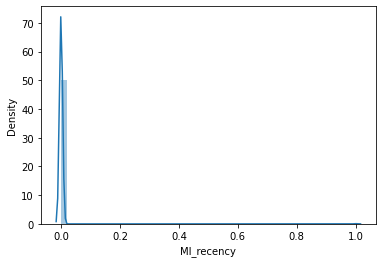

In [160]:
sns.distplot(data['MI_recency']>0)

In [164]:
data = data[data['MI_DX_Date_[d_from_CT]']>0]

/Users/hsahu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='MI_DX_Date_[d_from_CT]', ylabel='Density'>

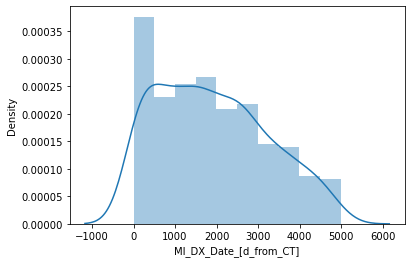

In [165]:
sns.distplot(data['MI_DX_Date_[d_from_CT]'])

In [95]:
# tmp = data[(data['MI']==1) & (data['MI_DX_Date_[d_from_CT]']>0)].copy()
# sns.lineplot(data=tmp, x='MI_DX_Date_[d_from_CT]', y='AoCa_Agatston')
# plt.show()

# tmp[tmp['MI_DX_Date_[d_from_CT]']>=2812]['AoCa_Agatston'].describe()
# data[data['MI']==0]['AoCa_Agatston'].describe()

# tmp['MI_DX_Date_[d_from_CT]'].describe()

# data.groupby('MI')['Age_at_CT'].describe()

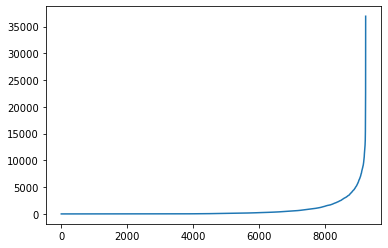

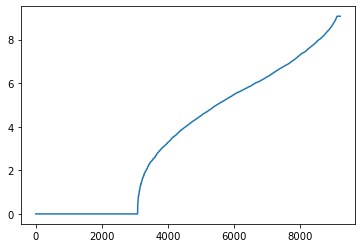

In [6]:
tmp = orig_data['AoCa_Agatston'].values
tmp = np.sort(tmp)
plt.plot(tmp)
plt.show()

tmp = data['AoCa_Agatston'].values
tmp = np.sort(tmp)
plt.plot(tmp)

In [ ]:
from sklearn.manifold import TSNE

n_components = 2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(train[feats])

tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': Y_train})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

BMI


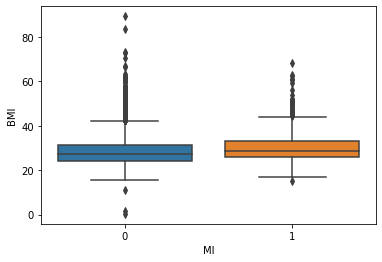

Age_at_CT


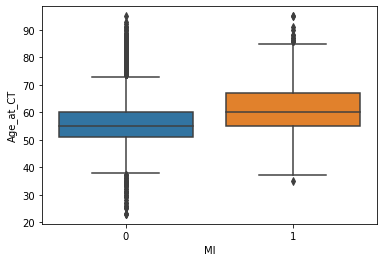

FRS_10-year_risk_(%)


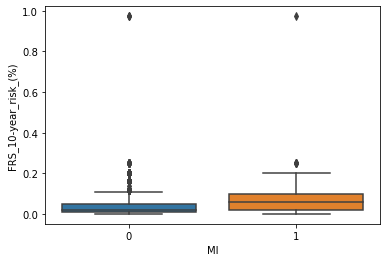

TAT_Area_(cm2)


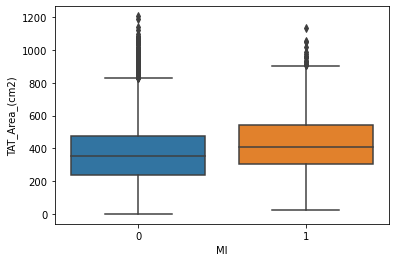

Total_Body_Area_EA_(cm2)


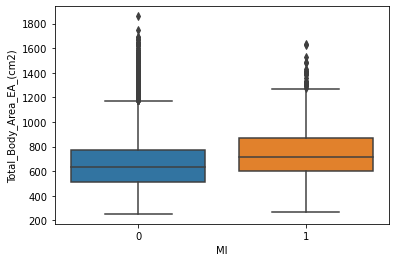

VAT_Area_(cm2)


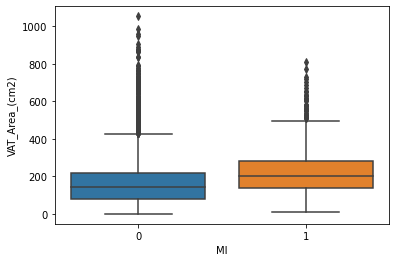

SAT_Area_(cm2)


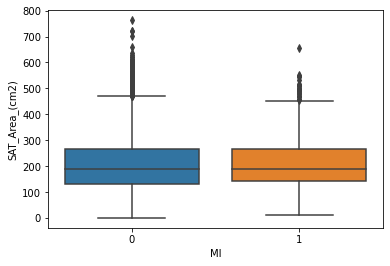

VAT/SAT_Ratio


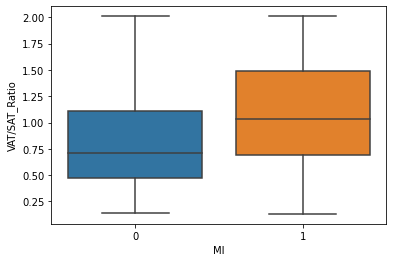

AoCa_Agatston


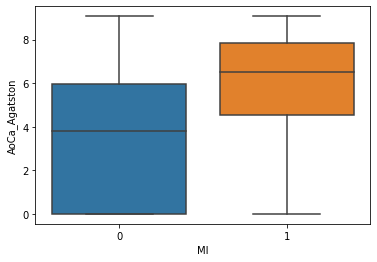

Liver_HU_(Median)


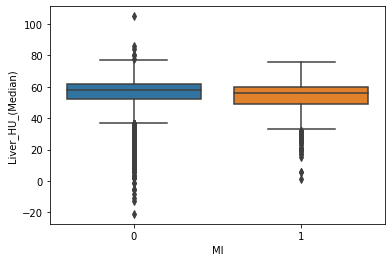

In [66]:
import seaborn as sns
for col in ['BMI','Age_at_CT','FRS_10-year_risk_(%)','TAT_Area_(cm2)','Total_Body_Area_EA_(cm2)','VAT_Area_(cm2)','SAT_Area_(cm2)',
'VAT/SAT_Ratio','AoCa_Agatston','Liver_HU_(Median)']:
    print(col)
    sns.boxplot(x='MI', y=col, data=data)
    plt.show()    

In [67]:
for col in ['Sex','Tobacco','CVD','Heart_failure']:
    print(data.groupby([col,'MI'])['MI'].count())

Sex  MI
0    0     4856
     1      296
1    0     3526
     1      545
Name: MI, dtype: int64
Tobacco  MI
0        0     5147
         1      344
1        0     3235
         1      497
Name: MI, dtype: int64
CVD  MI
0    0     7731
     1      745
1    0      651
     1       96
Name: MI, dtype: int64
Heart_failure  MI
0              0     7990
               1      753
1              0      392
               1       88
Name: MI, dtype: int64


BMI


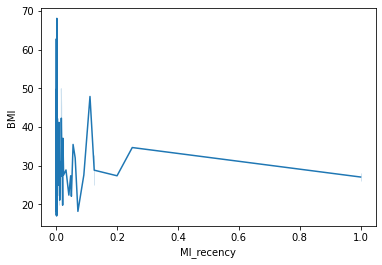

Age_at_CT


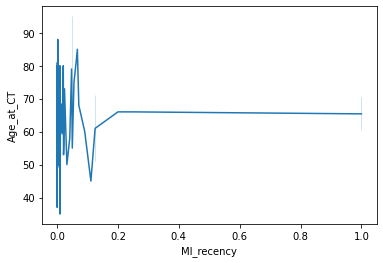

FRS_10-year_risk_(%)


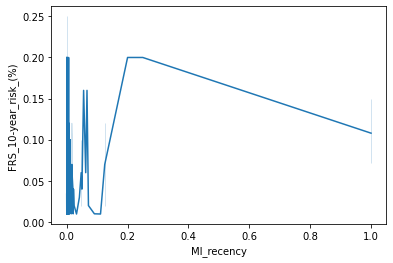

TAT_Area_(cm2)


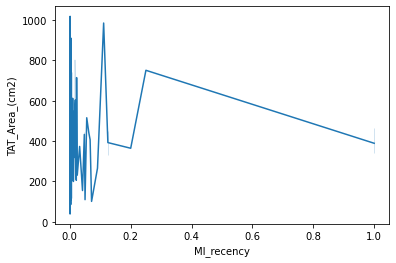

Total_Body_Area_EA_(cm2)


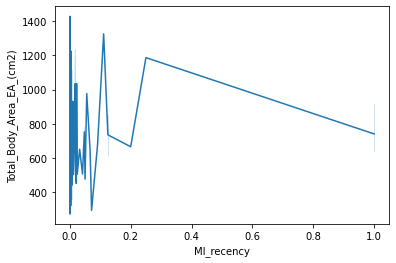

VAT_Area_(cm2)


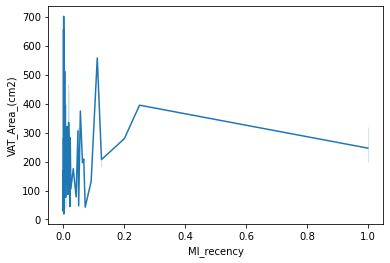

SAT_Area_(cm2)


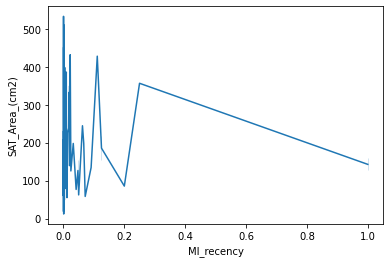

VAT/SAT_Ratio


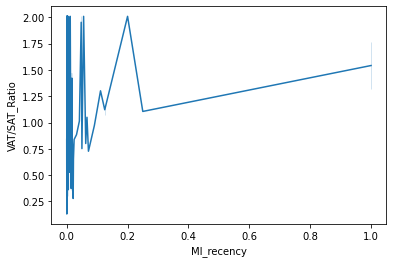

AoCa_Agatston


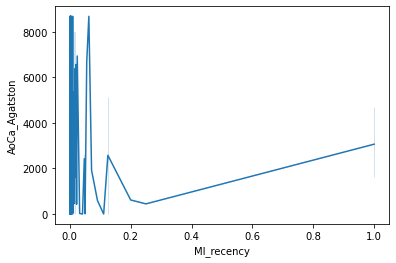

Liver_HU_(Median)


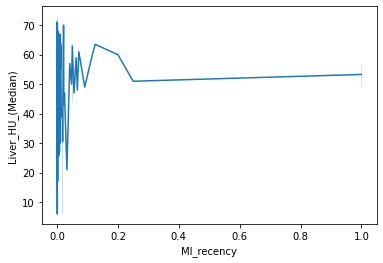

In [121]:
for col in ['BMI','Age_at_CT','FRS_10-year_risk_(%)','TAT_Area_(cm2)','Total_Body_Area_EA_(cm2)','VAT_Area_(cm2)','SAT_Area_(cm2)',
'VAT/SAT_Ratio','AoCa_Agatston','Liver_HU_(Median)']:
    print(col)
    sns.lineplot(x='MI_recency', y=col, data=data)
    plt.show()  

In [17]:
# msk = np.random.rand(data.shape[0]) < 0.8
# train = data[msk]
# test = data[~msk]
# train.to_csv('train.csv')
# test.to_csv('test.csv')

In [167]:
train_idx = pd.read_csv('train.csv')['Record_ID']
test_idx = pd.read_csv('test.csv')['Record_ID']
train = data[data['Record_ID'].isin(train_idx)]
test = data[data['Record_ID'].isin(test_idx)]
print(train.shape)
print(test.shape)

(338, 22)
(105, 22)


In [168]:
feats = ['BMI','Sex','Age_at_CT','Tobacco','FRS_10-year_risk_(%)','CVD','Heart_failure',
         'TAT_Area_(cm2)','Total_Body_Area_EA_(cm2)','VAT_Area_(cm2)','SAT_Area_(cm2)','VAT/SAT_Ratio',
         'AoCa_Agatston', 'Liver_HU_(Median)']
# label = 'MI'
label = 'MI_DX_Date_[d_from_CT]'
X_train = train[feats]
Y_train = train[label]

In [225]:
# model = LogisticRegression(random_state=0).fit(X_train, Y_train)

# model = LinearRegression().fit(X_train, Y_train)

from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(max_depth=5, random_state=0).fit(X_train, Y_train)

from sklearn.neural_network import MLPRegressor
model = MLPRegressor(hidden_layer_sizes=(15,15), learning_rate_init=0.01, max_iter=500).fit(X_train, Y_train)

In [226]:
# for col in feats:
#     test[col].fillna(na_dict[col], inplace=True)
X_test = test[feats]
Y_test = test[label]
preds = model.predict(X_test)
# accuracy_score(Y_test, preds)

rmse = math.sqrt(mean_squared_error(Y_test, preds))
print(rmse, Y_test.mean())

1258.7463102269573 1846.952380952381


<AxesSubplot:xlabel='Y_test', ylabel='preds'>

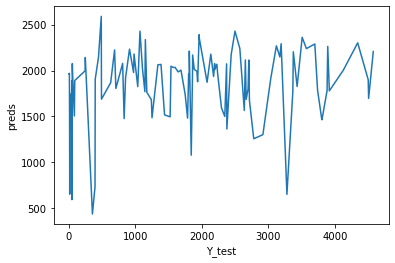

In [227]:
# tmp = pd.DataFrame([Y_test, preds], columns=['Y_test', 'preds'])
tmp = {'Y_test':Y_test, 'preds':preds}
sns.lineplot(data=tmp, x='Y_test', y='preds')

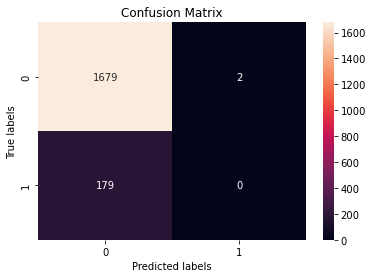

In [57]:
ax= plt.subplot()
cm = confusion_matrix(Y_test, preds)
labels = [0,1]
sns.heatmap(cm, annot=True, fmt='g', ax=ax);
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); 
ax.yaxis.set_ticklabels(labels);